In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
S, P = np.load("butadien/dataset.npy")
molecules = np.load("butadien/molecules.npy")

In [3]:
from SCFInitialGuess.utilities.dataset import Dataset

dim = 26

ind_cut = 150
index = np.arange(200)
np.random.shuffle(index)

S_test = np.array(S)[index[150:]]
P_test = np.array(P)[index[150:]]
molecules_test = [molecules[index[i]] for i in range(150, 200)]

S_train = np.array(S)[index[:150]]
P_train = np.array(P)[index[:150]]
molecules_train = [molecules[index[i]] for i in range(150)]

dataset = Dataset(np.array(S_train), np.array(P_train), split_test=0.0)

dataset.testing = (Dataset.normalize(S_test, mean=dataset.x_mean, std=dataset.x_std)[0], P_test)

[-] 2018-03-23 17:36:56: Data set normalized. Mean value std: 0.008717567076537439


# Training different costs

In [4]:
from SCFInitialGuess.nn.networks import EluTrNNN
from SCFInitialGuess.nn.training import Trainer, RegularizedMSE

trainer = Trainer(
    EluTrNNN([dim**2, 200, 100, dim**2]),
    cost_function=RegularizedMSE(alpha=1e-7)
)

trainer.setup()
network_orig, sess_orig = trainer.train(
    dataset,
    convergence_threshold=1e-7
)
graph_orig = trainer.graph

[-] 2018-03-23 17:36:56: No target graph specified for Trainer setup. Creating new graph ...
[-] 2018-03-23 17:36:56: Setting up the training in the target graph ...
[-] 2018-03-23 17:36:56: network ...
[-] 2018-03-23 17:36:56: error function ...
[-] 2018-03-23 17:36:56: cost function ...
[-] 2018-03-23 17:37:18: training step
[-] 2018-03-23 17:37:18: Starting network training ...
[ ] 2018-03-23 17:37:18: Val. Cost: 5.774E-02. Error: 5.774E-02. Diff: 1.0E+10
[ ] 2018-03-23 17:37:20: Val. Cost: 7.100E-05. Error: 6.967E-05. Diff: 5.8E-02
[ ] 2018-03-23 17:37:21: Val. Cost: 2.832E-05. Error: 2.700E-05. Diff: 4.3E-05
[ ] 2018-03-23 17:37:22: Val. Cost: 2.446E-05. Error: 2.313E-05. Diff: 3.9E-06
[ ] 2018-03-23 17:37:24: Val. Cost: 2.792E-05. Error: 2.659E-05. Diff: 3.5E-06
[ ] 2018-03-23 17:37:25: Val. Cost: 3.376E-05. Error: 3.241E-05. Diff: 5.8E-06
[ ] 2018-03-23 17:37:26: Val. Cost: 1.715E-05. Error: 1.579E-05. Diff: 1.7E-05
[ ] 2018-03-23 17:37:28: Val. Cost: 1.777E-05. Error: 1.640E-05

### Check symmetry

0.000579508


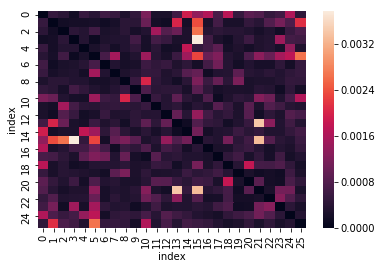

In [5]:
from SCFInitialGuess.utilities.plotutils import matrix_error

with graph_orig.as_default():
    reshaped = tf.reshape(network_orig.output_tensor, [-1, dim, dim])
    transposed = tf.matrix_transpose(reshaped)
    diff_mean = tf.reduce_mean(tf.abs(reshaped - transposed), axis=0)
    error = sess_orig.run(diff_mean, {network_orig.input_tensor: dataset.testing[0]})
    
    matrix_error(error)
    print(np.mean(error))

plt.show()

0.953793


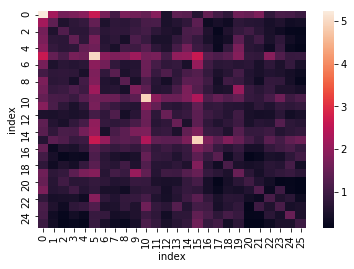

In [6]:
from SCFInitialGuess.utilities.plotutils import matrix_error

def idempotency_error(network):
    p = tf.reshape(network.output_tensor, [-1, dim, dim])
    s = tf.reshape(network.input_tensor, [-1, dim, dim])
    
    lhs = tf.matmul(tf.matmul(p, s), p)
    rhs = 2 * p
    return tf.reduce_mean(tf.abs(lhs - rhs), axis=0)

with graph_orig.as_default():
    
    
    """
    reshaped = tf.reshape(network_orig.output_tensor, [-1, dim, dim])
    squared = tf.matmul(reshaped, reshaped)
    diff_mean = tf.reduce_mean(tf.abs(reshaped - squared), axis=0)
    error = sess_orig.run(diff_mean, {network_orig.input_tensor: dataset.testing[0]})
    """
    error = sess_orig.run(
        idempotency_error(network_orig),
       {network_orig.input_tensor: dataset.testing[0]}
    )
    
    matrix_error(error)
    print(np.mean(error))
    
plt.show()

## Enforce hermiticity

In [7]:
from SCFInitialGuess.nn.networks import EluTrNNN
from SCFInitialGuess.nn.training import Trainer, MSE

class SymmetryPenalty(MSE):
    def __init__(self, coupling=1e-4):
        """alpha: coupling parameter"""
        
        self.coupling = coupling
        
    def function(self, network, y_placeholder):

        error = \
            super(SymmetryPenalty, self).function(network, y_placeholder)

        penalty = self.symmetry_measure(network.output_tensor) * self.coupling

        cost = error + penalty

        tf.summary.scalar("symmetry_penalty", penalty)
        tf.summary.scalar("total_loss", cost)

        return cost
    
    def symmetry_measure(self, output_tensor):
        
        reshaped = tf.reshape(output_tensor, [-1, dim, dim])
        transposed = tf.matrix_transpose(reshaped)
        return tf.reduce_mean(tf.norm(reshaped - transposed, axis=(1,2))**2 )

    
trainer_sym = Trainer(
    EluTrNNN([dim**2, 200, 100, dim**2]),
    cost_function=SymmetryPenalty(coupling=5e-2)
)

trainer_sym.setup()
network_sym, sess_sym = trainer_sym.train(
    dataset,
    convergence_threshold=1e-6
)
graph_sym = trainer_sym.graph
        

[-] 2018-03-23 17:38:03: No target graph specified for Trainer setup. Creating new graph ...
[-] 2018-03-23 17:38:03: Setting up the training in the target graph ...
[-] 2018-03-23 17:38:03: network ...
[-] 2018-03-23 17:38:03: error function ...
[-] 2018-03-23 17:38:03: cost function ...
[-] 2018-03-23 17:38:03: training step
[-] 2018-03-23 17:38:03: Starting network training ...
[ ] 2018-03-23 17:38:03: Val. Cost: 6.362E-02. Error: 5.800E-02. Diff: 1.0E+10
[ ] 2018-03-23 17:38:05: Val. Cost: 5.246E-04. Error: 3.060E-04. Diff: 5.8E-02
[ ] 2018-03-23 17:38:06: Val. Cost: 2.696E-04. Error: 1.606E-04. Diff: 1.5E-04
[ ] 2018-03-23 17:38:08: Val. Cost: 2.295E-04. Error: 1.889E-04. Diff: 2.8E-05
[ ] 2018-03-23 17:38:10: Val. Cost: 3.013E-04. Error: 1.005E-04. Diff: 8.8E-05
[ ] 2018-03-23 17:38:11: Val. Cost: 8.469E-05. Error: 6.539E-05. Diff: 3.5E-05
[ ] 2018-03-23 17:38:12: Val. Cost: 6.813E-05. Error: 4.220E-05. Diff: 2.3E-05
[ ] 2018-03-23 17:38:14: Val. Cost: 1.692E-04. Error: 1.013E-04

0.00113552


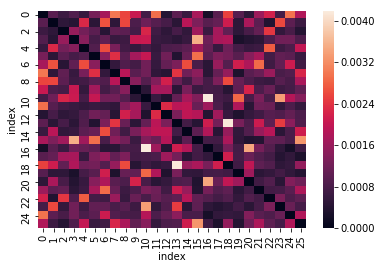

In [8]:
with graph_sym.as_default():
    reshaped = tf.reshape(network_sym.output_tensor, [-1, dim, dim])
    transposed = tf.matrix_transpose(reshaped)
    diff_mean = tf.reduce_mean(tf.abs(reshaped - transposed), axis=0)
    error = sess_sym.run(diff_mean, {network_sym.input_tensor: dataset.testing[0]})
    matrix_error(error)
    print(np.mean(error))

plt.show()

## Enforce idempotency

In [9]:
from SCFInitialGuess.nn.networks import EluTrNNN
from SCFInitialGuess.nn.training import Trainer, MSE

class IdempotencyPenalty(MSE):
    def __init__(self, coupling=1e-4):
        
        self.coupling = coupling
        
    def function(self, network, y_placeholder):

        error = \
            super(IdempotencyPenalty, self).function(network, y_placeholder)

        penalty = self.idempotency_error(network) * self.coupling

        cost = error + penalty

        tf.summary.scalar("symmetry_penalty", penalty)
        tf.summary.scalar("total_loss", cost)

        return cost
    
    def idempotency_error(self, network):
        p = tf.reshape(network.output_tensor, [-1, dim, dim])
        s_raw = dataset.inverse_input_transform(network.input_tensor)
        s = tf.reshape(s_raw, [-1, dim, dim])
        

        lhs = tf.matmul(tf.matmul(p, s), p)
        rhs = 2 * p
        return tf.reduce_mean(tf.norm(tf.abs(lhs - rhs), axis=(1,2)) **2 )

try:
    del graph_idem
except:
    pass
    
trainer = Trainer(
    EluTrNNN([dim**2, 200, 100, dim**2]),
    cost_function=IdempotencyPenalty(coupling=1e-5)
)

trainer.setup()
network_idem, sess_idem = trainer.train(
    dataset,
    convergence_threshold=3e-6,
    summary_save_path="log2/idem"
)
graph_idem = trainer.graph

[-] 2018-03-23 17:38:29: No target graph specified for Trainer setup. Creating new graph ...
[-] 2018-03-23 17:38:29: Setting up the training in the target graph ...
[-] 2018-03-23 17:38:29: network ...
[-] 2018-03-23 17:38:29: error function ...
[-] 2018-03-23 17:38:29: cost function ...
[-] 2018-03-23 17:38:29: training step
[-] 2018-03-23 17:38:29: Starting network training ...
[ ] 2018-03-23 17:38:29: Val. Cost: 5.833E-02. Error: 5.832E-02. Diff: 1.0E+10
[ ] 2018-03-23 17:38:32: Val. Cost: 6.343E-03. Error: 2.573E-03. Diff: 5.6E-02
[ ] 2018-03-23 17:38:34: Val. Cost: 6.141E-03. Error: 2.407E-03. Diff: 1.7E-04
[ ] 2018-03-23 17:38:36: Val. Cost: 6.209E-03. Error: 2.456E-03. Diff: 4.9E-05
[ ] 2018-03-23 17:38:38: Val. Cost: 6.065E-03. Error: 2.386E-03. Diff: 7.0E-05
[ ] 2018-03-23 17:38:40: Val. Cost: 6.059E-03. Error: 2.366E-03. Diff: 2.0E-05
[ ] 2018-03-23 17:38:42: Val. Cost: 6.035E-03. Error: 2.457E-03. Diff: 9.1E-05
[ ] 2018-03-23 17:38:44: Val. Cost: 6.018E-03. Error: 2.391E-03

0.519894


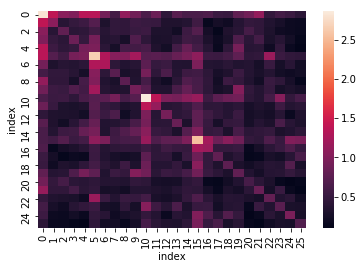

In [10]:
with graph_idem.as_default():
    error = sess_idem.run(idempotency_error(network_idem), {network_idem.input_tensor: dataset.testing[0]})
    
    matrix_error(error)
    print(np.mean(error))
    
plt.show()
    
    

# Analysis

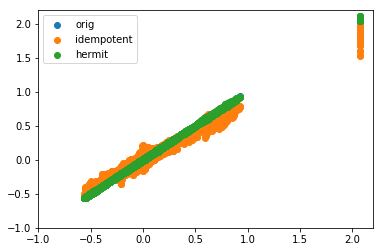

In [12]:
with graph_orig.as_default():
    plt.scatter(
        x=dataset.testing[1],
        y=network_orig.run(sess_orig, dataset.testing[0]),
        label="orig"
    )
    
with graph_idem.as_default():
    plt.scatter(
        x=dataset.testing[1],
        y=network_idem.run(sess_idem, dataset.testing[0]),
        label="idempotent"
    )
    

with graph_sym.as_default():
    plt.scatter(
        x=dataset.testing[1],
        y=network_sym.run(sess_sym, dataset.testing[0]),
        label="hermit"
    )

#lower = 1.8
lower = -1
upper = 2.2
plt.xlim([lower, upper])
plt.ylim([lower, upper])
    

plt.legend()
plt.show()

In [23]:
from pyscf.scf import hf
from SCFInitialGuess.utilities.plotutils import prediction_scatter

dim = 26

def idemp_error(p, s):
    p = p.reshape(dim, dim)
    s = s.reshape(dim, dim)
    return np.mean(np.abs(np.dot(np.dot(p, s), p) - 2 * p))

iterations = []
for i, (molecule, p) in enumerate(zip(molecules_test, P_test)):
    
    mol = molecule.get_pyscf_molecule()
    
    
    print("Calculating: " + str(i + 1) + "/" + str(len(molecules_test)))
    
    # nn guess
    s_raw = hf.get_ovlp(mol).reshape(1, dim**2)
    s = Dataset.normalize(s_raw, mean=dataset.x_mean, std=dataset.x_std)[0]
    
    with graph_orig.as_default():
        P_orig = network_orig.run(sess_orig, s).reshape(dim, dim).astype('float64')
        
        print("idemp orig: " + str(idemp_error(p, s_raw)))
        print("Idemp before: " + str(idemp_error(P_orig, s_raw)))
        
    with graph_idem.as_default():
        P_idem = network_idem.run(sess_idem, s).reshape(dim, dim).astype('float64')
    
    with graph_sym.as_default():
        P_sym = network_sym.run(sess_sym, s).reshape(dim, dim).astype('float64')
    
    
    # P_actual wi noise
    p_noise = p.reshape(dim, dim) + np.random.randn(dim, dim) * 5e-3
    
    
    iterations_molecule = []
    for guess in [p_noise, P_orig, P_idem, P_sym]:
        
        mf = hf.RHF(mol)
        mf.diis = None
        mf.verbose = 1
        mf.kernel(dm0=guess)
        iterations_molecule.append(mf.iterations)
    
    iterations.append(iterations_molecule)

iterations = np.array(iterations)

Warn: Ipython shell catchs sys.args


Calculating: 1/50
idemp orig: 2.72649681181e-16
Idemp before: 0.00214295086152


Warn: Ipython shell catchs sys.args


Calculating: 2/50
idemp orig: 3.60651753238e-16
Idemp before: 0.00195091611667


Warn: Ipython shell catchs sys.args


Calculating: 3/50
idemp orig: 3.58110694492e-16
Idemp before: 0.00213634271624


Warn: Ipython shell catchs sys.args


Calculating: 4/50
idemp orig: 3.42403235326e-16
Idemp before: 0.00161936248852


Warn: Ipython shell catchs sys.args


Calculating: 5/50
idemp orig: 3.42486314723e-16
Idemp before: 0.00133744838331


Warn: Ipython shell catchs sys.args


Calculating: 6/50
idemp orig: 3.06320634179e-16
Idemp before: 0.00109842940566


Warn: Ipython shell catchs sys.args


Calculating: 7/50
idemp orig: 2.70386349002e-16
Idemp before: 0.00166820793948


Warn: Ipython shell catchs sys.args


Calculating: 8/50
idemp orig: 3.13839720592e-16
Idemp before: 0.00129790068785


Warn: Ipython shell catchs sys.args


Calculating: 9/50
idemp orig: 2.8497805026e-16
Idemp before: 0.00127745900401


Warn: Ipython shell catchs sys.args


Calculating: 10/50
idemp orig: 3.47344534843e-16
Idemp before: 0.00218852493354


Warn: Ipython shell catchs sys.args


Calculating: 11/50
idemp orig: 3.69363622425e-16
Idemp before: 0.00180543644539


Warn: Ipython shell catchs sys.args


Calculating: 12/50
idemp orig: 3.26616385616e-16
Idemp before: 0.00172664448763


Warn: Ipython shell catchs sys.args


Calculating: 13/50
idemp orig: 3.38055680845e-16
Idemp before: 0.00164929453254


Warn: Ipython shell catchs sys.args


Calculating: 14/50
idemp orig: 3.36339080867e-16
Idemp before: 0.00168473839177


Warn: Ipython shell catchs sys.args


Calculating: 15/50
idemp orig: 3.17462896505e-16
Idemp before: 0.00158197797228


Warn: Ipython shell catchs sys.args


Calculating: 16/50
idemp orig: 3.22821798301e-16
Idemp before: 0.00115228772267


Warn: Ipython shell catchs sys.args


Calculating: 17/50
idemp orig: 3.625175914e-16
Idemp before: 0.00223683470647


Warn: Ipython shell catchs sys.args


Calculating: 18/50
idemp orig: 3.4959489589e-16
Idemp before: 0.0015657809498


Warn: Ipython shell catchs sys.args


Calculating: 19/50
idemp orig: 3.70587199108e-16
Idemp before: 0.00127390941678


Warn: Ipython shell catchs sys.args


Calculating: 20/50
idemp orig: 3.12636592988e-16
Idemp before: 0.00138913982102


Warn: Ipython shell catchs sys.args


Calculating: 21/50
idemp orig: 3.30895616114e-16
Idemp before: 0.00126397273833


Warn: Ipython shell catchs sys.args


Calculating: 22/50
idemp orig: 3.03018709293e-16
Idemp before: 0.00149491528843


Warn: Ipython shell catchs sys.args


Calculating: 23/50
idemp orig: 3.04426327691e-16
Idemp before: 0.00161790268061


Warn: Ipython shell catchs sys.args


Calculating: 24/50
idemp orig: 2.86267063996e-16
Idemp before: 0.00162405230574


Warn: Ipython shell catchs sys.args


Calculating: 25/50
idemp orig: 3.28295134749e-16
Idemp before: 0.00159532652848


Warn: Ipython shell catchs sys.args


Calculating: 26/50
idemp orig: 3.32282785432e-16
Idemp before: 0.00137575934421


Warn: Ipython shell catchs sys.args


Calculating: 27/50
idemp orig: 2.94182621973e-16
Idemp before: 0.001225587172


Warn: Ipython shell catchs sys.args


Calculating: 28/50
idemp orig: 3.49695617631e-16
Idemp before: 0.0012680793062


Warn: Ipython shell catchs sys.args


Calculating: 29/50
idemp orig: 2.98473159608e-16
Idemp before: 0.00143851754971


Warn: Ipython shell catchs sys.args


Calculating: 30/50
idemp orig: 3.49237317674e-16
Idemp before: 0.001674650418


Warn: Ipython shell catchs sys.args


Calculating: 31/50
idemp orig: 3.5626594695e-16
Idemp before: 0.00138523469837


Warn: Ipython shell catchs sys.args


Calculating: 32/50
idemp orig: 3.1074389035e-16
Idemp before: 0.00138423626818


Warn: Ipython shell catchs sys.args


Calculating: 33/50
idemp orig: 3.75913582858e-16
Idemp before: 0.00131716601958


Warn: Ipython shell catchs sys.args


Calculating: 34/50
idemp orig: 3.28938398634e-16
Idemp before: 0.00179851301681


Warn: Ipython shell catchs sys.args


Calculating: 35/50
idemp orig: 2.98958484427e-16
Idemp before: 0.00121582273102


Warn: Ipython shell catchs sys.args


Calculating: 36/50
idemp orig: 3.34737156119e-16
Idemp before: 0.00177113508645


Warn: Ipython shell catchs sys.args


Calculating: 37/50
idemp orig: 2.6777019001e-16
Idemp before: 0.00150548757903


Warn: Ipython shell catchs sys.args


Calculating: 38/50
idemp orig: 3.9696939851e-16
Idemp before: 0.00134806365831


Warn: Ipython shell catchs sys.args


Calculating: 39/50
idemp orig: 3.51408207985e-16
Idemp before: 0.00140734378501


Warn: Ipython shell catchs sys.args


Calculating: 40/50
idemp orig: 3.19092086693e-16
Idemp before: 0.00137244321984


Warn: Ipython shell catchs sys.args


Calculating: 41/50
idemp orig: 2.84245010906e-16
Idemp before: 0.00108973307504


Warn: Ipython shell catchs sys.args


Calculating: 42/50
idemp orig: 2.82971474316e-16
Idemp before: 0.00156167635526


Warn: Ipython shell catchs sys.args


Calculating: 43/50
idemp orig: 3.92754803142e-16
Idemp before: 0.00215212778499


Warn: Ipython shell catchs sys.args


Calculating: 44/50
idemp orig: 3.35668190677e-16
Idemp before: 0.00158594542618


Warn: Ipython shell catchs sys.args


Calculating: 45/50
idemp orig: 3.26120074429e-16
Idemp before: 0.00171744102735


Warn: Ipython shell catchs sys.args


Calculating: 46/50
idemp orig: 3.18500206132e-16
Idemp before: 0.00160987417416


Warn: Ipython shell catchs sys.args


Calculating: 47/50
idemp orig: 2.91810248084e-16
Idemp before: 0.00147976200557


Warn: Ipython shell catchs sys.args


Calculating: 48/50
idemp orig: 3.2700018677e-16
Idemp before: 0.00184499612645


Warn: Ipython shell catchs sys.args


Calculating: 49/50
idemp orig: 3.00502029058e-16
Idemp before: 0.00170207475217


Warn: Ipython shell catchs sys.args


Calculating: 50/50
idemp orig: 3.15145173784e-16
Idemp before: 0.00148397442974


In [22]:
print("noise", "orig", "idem", "sym")
print(np.mean(iterations,0))

noise orig idem sym
[  9.86  10.74  21.82  14.26]


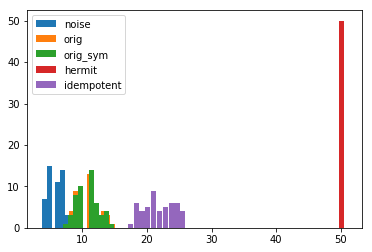

In [15]:

bins = 20 # todo hier kann man auch ein array angeben

for i, name in enumerate(['noise', 'orig', 'orig_sym', 'hermit', 'idempotent']):
    
    hist, bins = np.histogram(iterations[:,i])
    center = (bins[:-1] + bins[1:]) / 2
    #axes[i].bar(center, hist, label=name)
    plt.bar(center, hist, label=name)
    
plt.legend()
plt.show()